In [177]:
# Spatial Transcriptomic Data Analysis Tutorial
# Normalization in Detail

# Example Data:
# Hepatocellular carcinoma (HCC) resection specimens
# Publication link: https://pubmed.ncbi.nlm.nih.gov/37723590/

# By: Ashok K. Sharma
# Date: 11-17-2024

In [178]:
#Raw Data: Emphasize variability and batch effects.
#Normalization: Show how it adjusts for total counts.
#Log Transformation: Demonstrate its impact on compressing large differences.
#Filtering: Discuss why we remove low-quality data.
#Scaling: Explain its role in downstream analyses like PCA or clustering.

In [179]:
# Libraries
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [182]:
# Load Ann Data Object
adata = sc.read('data/GSE238264_AnnDataObject.h5ad') # Load the Data Again

# To divide Samples in to the Group - Note: This step needs to be sutomized based on the Sample Names and metadata
# Sample names ends with NR are NonResponder and R are Responder
# Add a new column 'response_category' to classify each sample
adata.obs['response_category'] = adata.obs['sample'].apply(
    lambda x: 'NonResponder' if x.endswith('NR') else 'Responder'
)

# Check to ensure the new column is added and categories are correct
print(adata.obs[['sample', 'response_category']].head())

## Save raw data before any processing
adata_org = adata.copy()
adata

                           sample response_category
AAACAGAGCGACTCCT-1-HCC5NR  HCC5NR      NonResponder
AAACAGCTTTCAGAAG-1-HCC5NR  HCC5NR      NonResponder
AAACAGGGTCTATATT-1-HCC5NR  HCC5NR      NonResponder
AAACCGGGTAGGTACC-1-HCC5NR  HCC5NR      NonResponder
AAACCTCATGAAGTTG-1-HCC5NR  HCC5NR      NonResponder


AnnData object with n_obs × n_vars = 17292 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'center_x', 'center_y', 'response_category'
    var: 'gene_ids', 'feature_types'
    obsm: 'spatial'

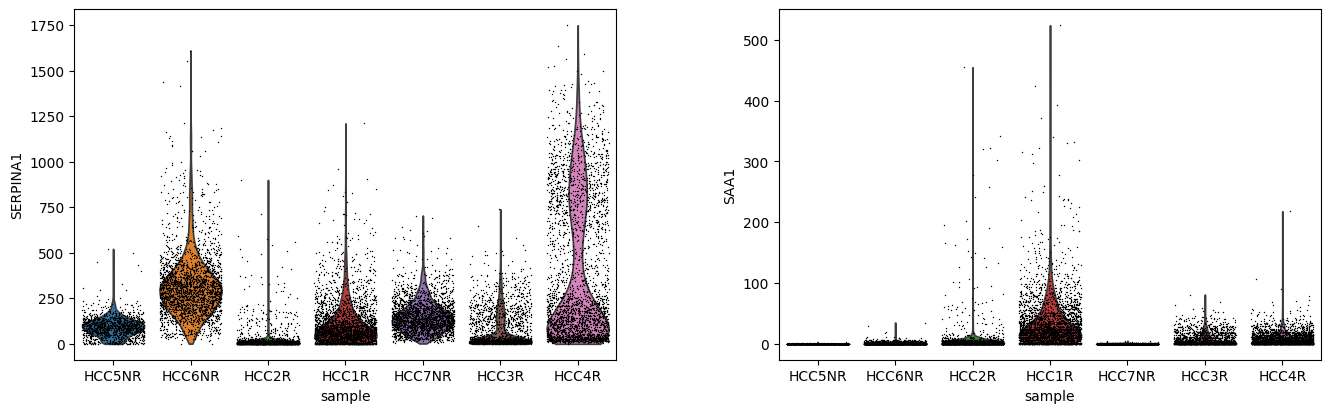

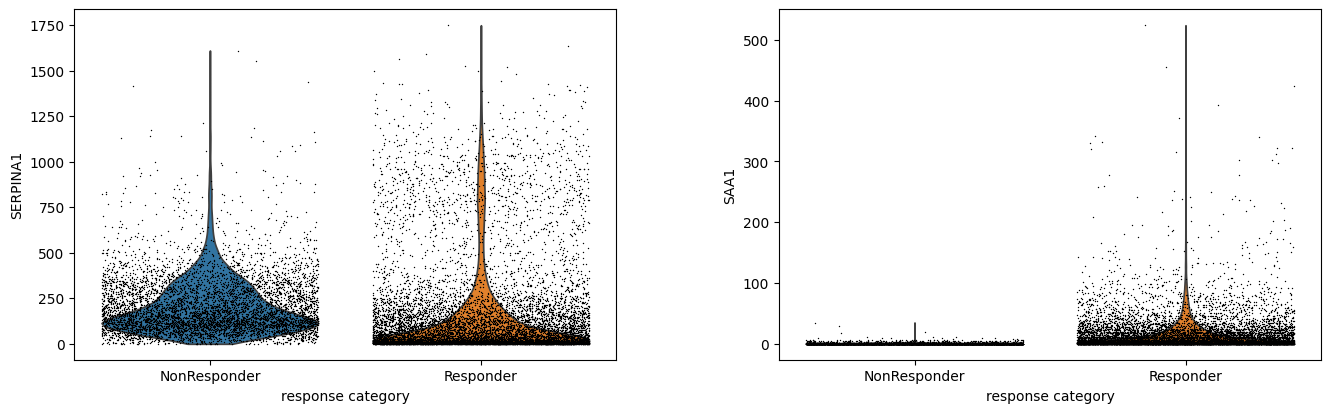

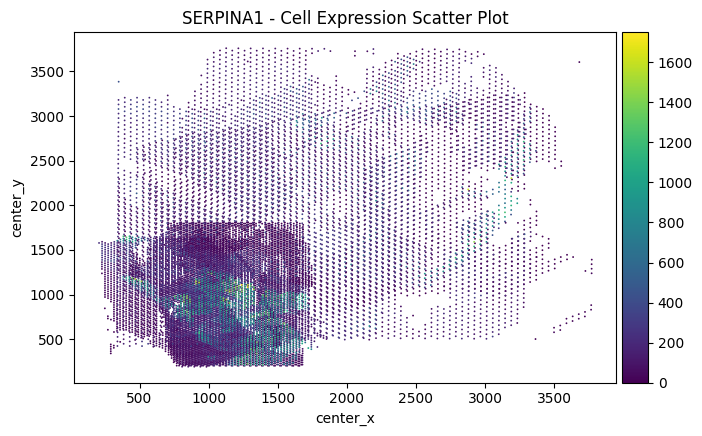

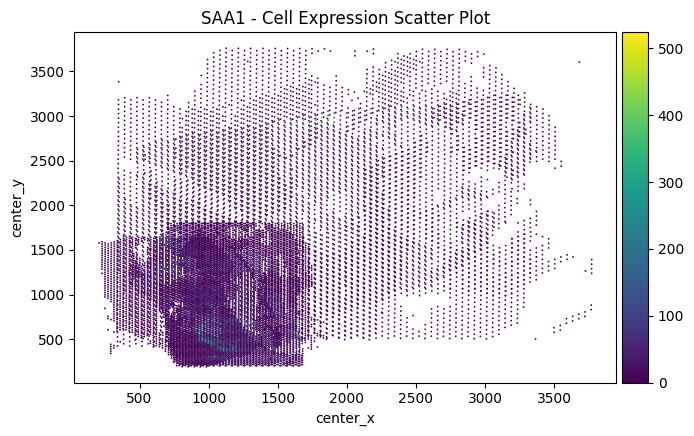

In [183]:
#1. Raw Data Visualization
#Concept: Before normalization, visualize the raw gene expression data to highlight differences in distribution and potential biases.

gene1 = "SERPINA1"
gene2 = "SAA1"

# Violin plot for raw data
sc.pl.violin(adata, keys=[gene1, gene2], groupby='sample', jitter=0.4, multi_panel=True)
sc.pl.violin(adata, keys=[gene1, gene2], groupby='response_category', jitter=0.4, multi_panel=True)

# Scatter plot for spatial visualization
sc.pl.scatter(adata, x='center_x', y='center_y', color=gene1, color_map='viridis', 
              title='SERPINA1 - Cell Expression Scatter Plot', show=True)
sc.pl.scatter(adata, x='center_x', y='center_y', color=gene2, color_map='viridis', 
              title='SAA1 - Cell Expression Scatter Plot', show=True)

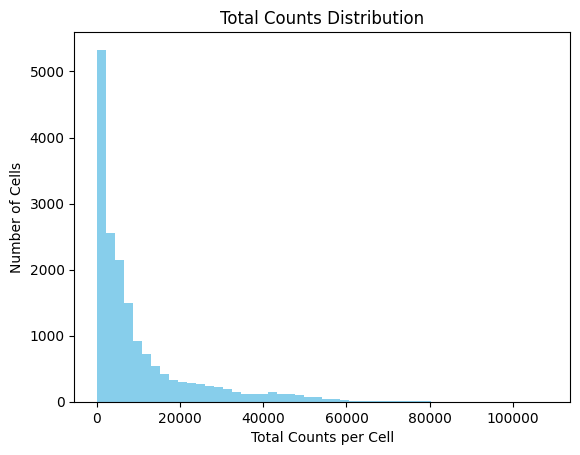

Median total count: 5040.0


AAACAGAGCGACTCCT-1-HCC5NR    0.556349
AAACAGCTTTCAGAAG-1-HCC5NR    1.358333
AAACAGGGTCTATATT-1-HCC5NR    0.896429
AAACCGGGTAGGTACC-1-HCC5NR    1.282143
AAACCTCATGAAGTTG-1-HCC5NR    1.176984
                               ...   
TTGTTGTGTGTCAAGA-1-HCC4R     2.313095
TTGTTTCACATCCAGG-1-HCC4R     9.200793
TTGTTTCATTAGTCTA-1-HCC4R     9.136111
TTGTTTCCATACAACT-1-HCC4R     2.183135
TTGTTTGTGTAAATTC-1-HCC4R     0.133333
Name: size_factors, Length: 17292, dtype: float32

In [184]:
#2. Library Effect Size
# Concept: Total counts per cell can vary significantly. This introduces bias that normalization addresses.
adata.obs['total_counts'] = adata.X.sum(axis=1)

# Histogram of total counts
plt.hist(adata.obs['total_counts'], bins=50, color='skyblue')
plt.xlabel('Total Counts per Cell')
plt.ylabel('Number of Cells')
plt.title('Total Counts Distribution')
plt.show()

# Calculate size factors (normalized to the median total counts)
median_total_counts = np.median(adata.obs['total_counts'])
print("Median total count:", median_total_counts)

adata.obs['size_factors'] = adata.obs['total_counts'] / median_total_counts
adata.obs['size_factors']

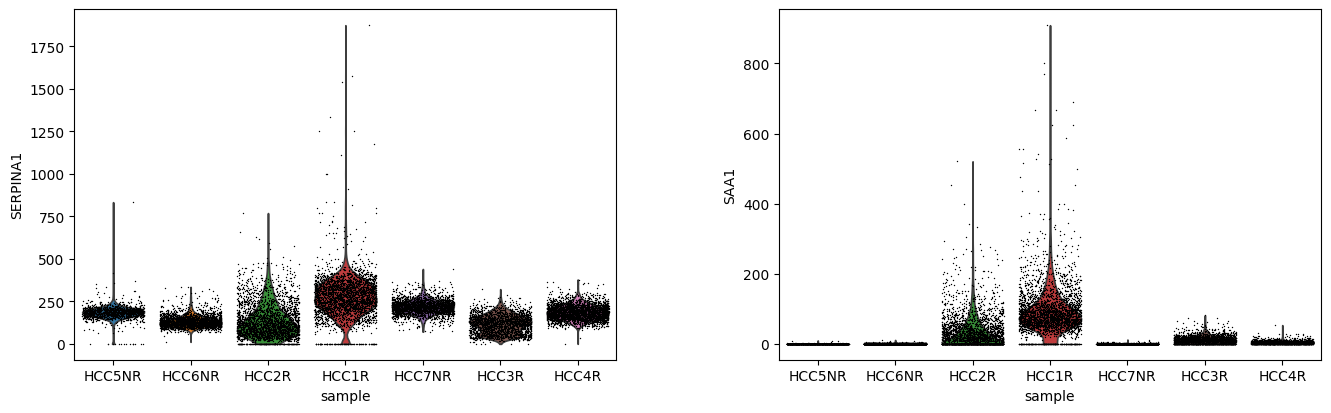

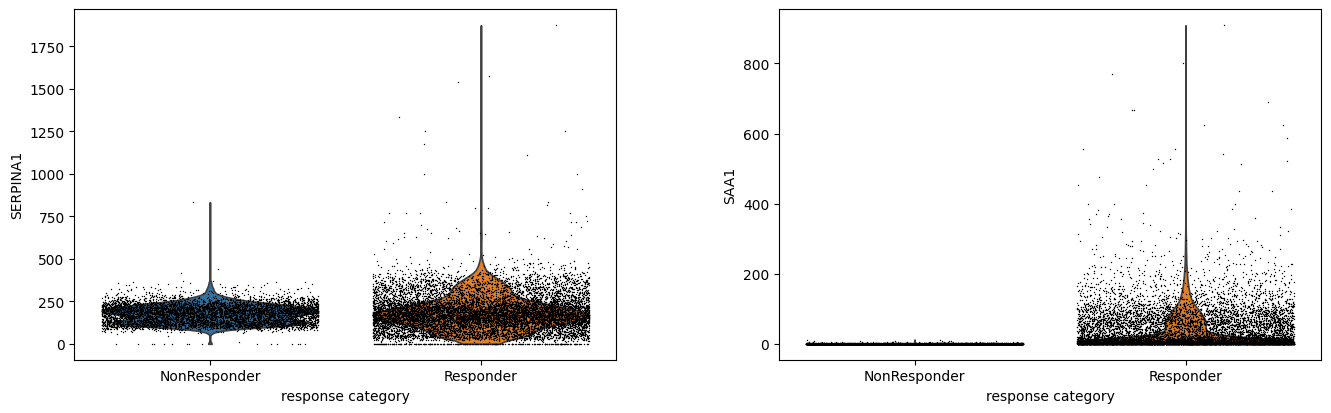

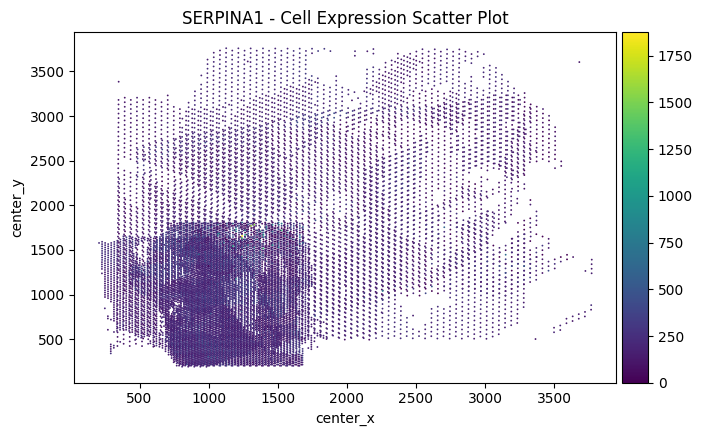

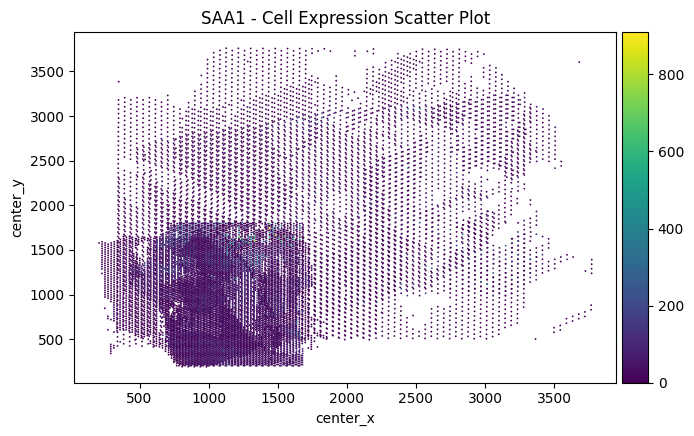

In [185]:
#3. Normalization (Scaling to Median Library Size)
# Concept: Normalize gene counts by scaling them to the median total count across all cells.
#sc.pp.normalize_total(adata, target_sum=median_total_counts)

# Normalize per cell: scale to 10,000 (counts per 10k)
sc.pp.normalize_total(adata, target_sum=1e4)

# Recompute violin and scatter plots after normalization
sc.pl.violin(adata, keys=[gene1, gene2], groupby='sample', jitter=0.4, multi_panel=True)
sc.pl.violin(adata, keys=[gene1, gene2], groupby='response_category', jitter=0.4, multi_panel=True)

sc.pl.scatter(adata, x='center_x', y='center_y', color=gene1, color_map='viridis', 
              title='SERPINA1 - Cell Expression Scatter Plot', show=True)
sc.pl.scatter(adata, x='center_x', y='center_y', color=gene2, color_map='viridis', 
              title='SAA1 - Cell Expression Scatter Plot', show=True)

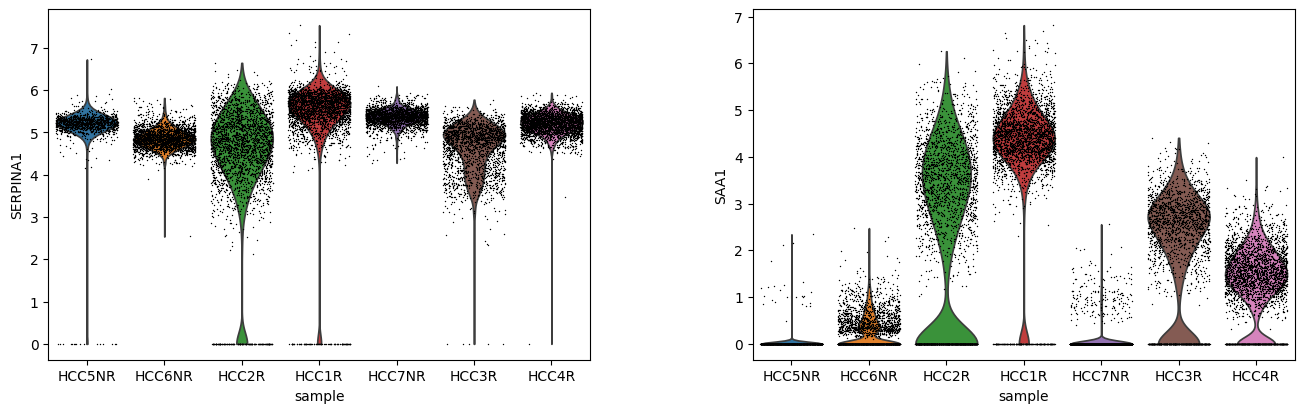

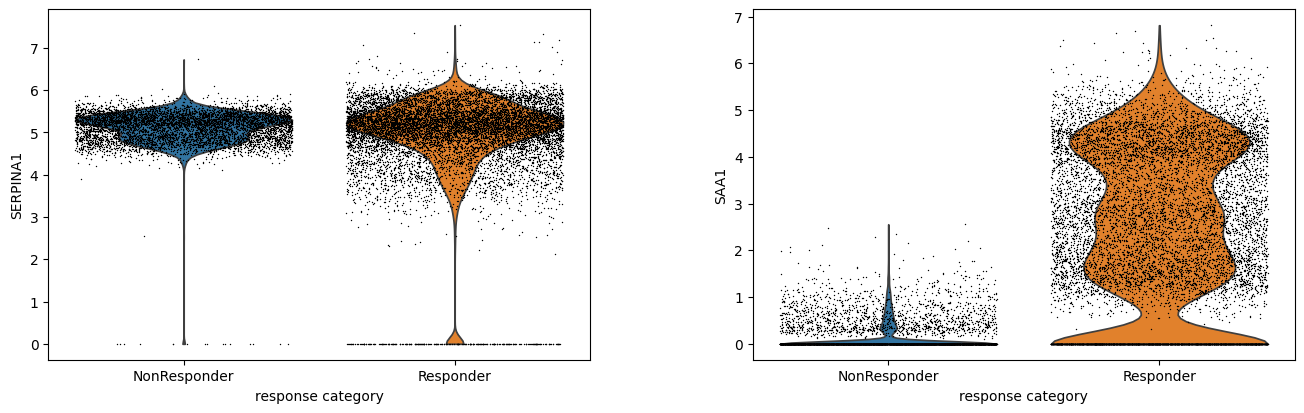

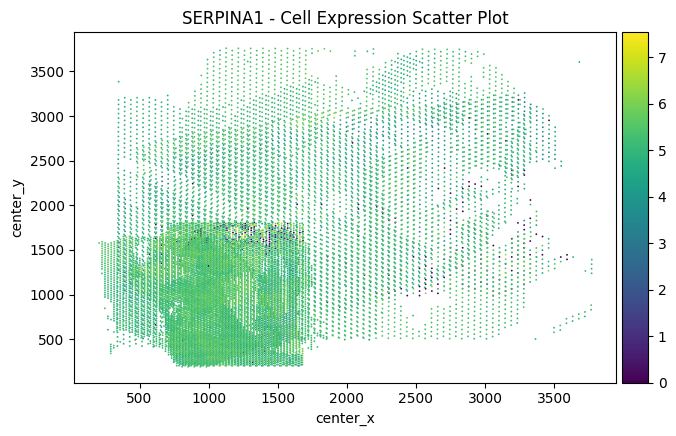

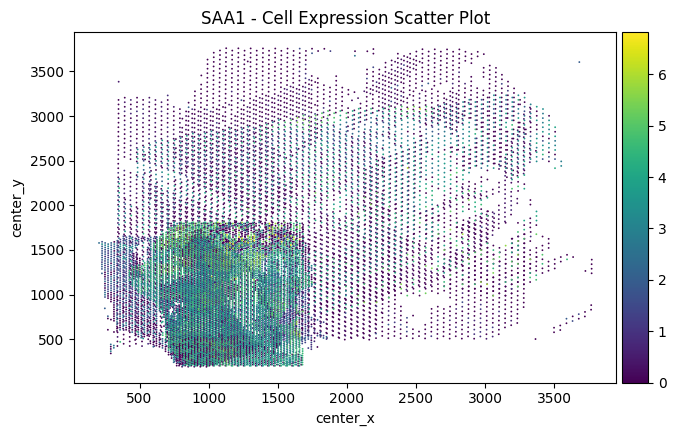

In [186]:
#4. Log Transformation
# Concept: Apply a log transform to normalize the dynamic range of gene expression values
# Log-transform normalized data
sc.pp.log1p(adata)

# Violin and scatter plot after log transformation
# Recompute violin and scatter plots after normalization
sc.pl.violin(adata, keys=[gene1, gene2], groupby='sample', jitter=0.4, multi_panel=True)
sc.pl.violin(adata, keys=[gene1, gene2], groupby='response_category', jitter=0.4, multi_panel=True)

sc.pl.scatter(adata, x='center_x', y='center_y', color=gene1, color_map='viridis', 
              title='SERPINA1 - Cell Expression Scatter Plot', show=True)
sc.pl.scatter(adata, x='center_x', y='center_y', color=gene2, color_map='viridis', 
              title='SAA1 - Cell Expression Scatter Plot', show=True)

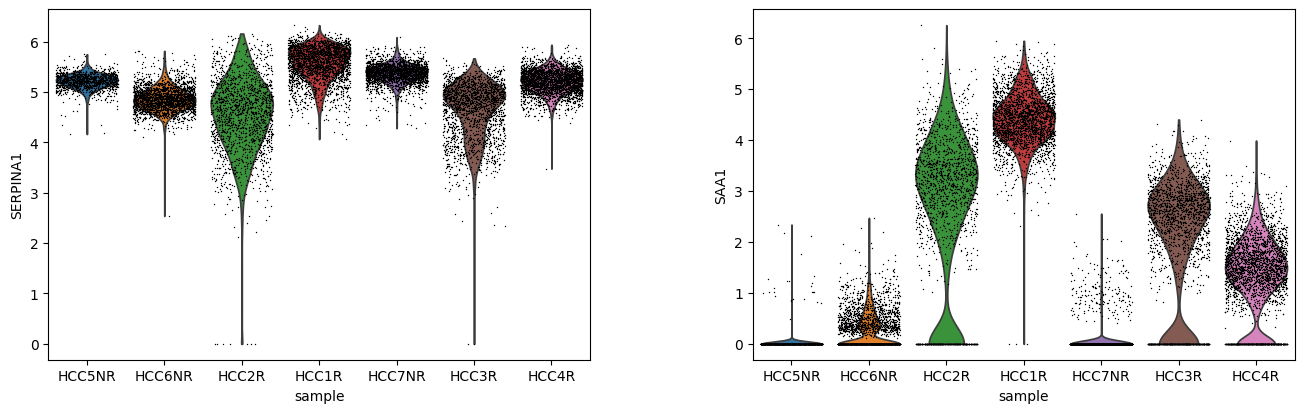

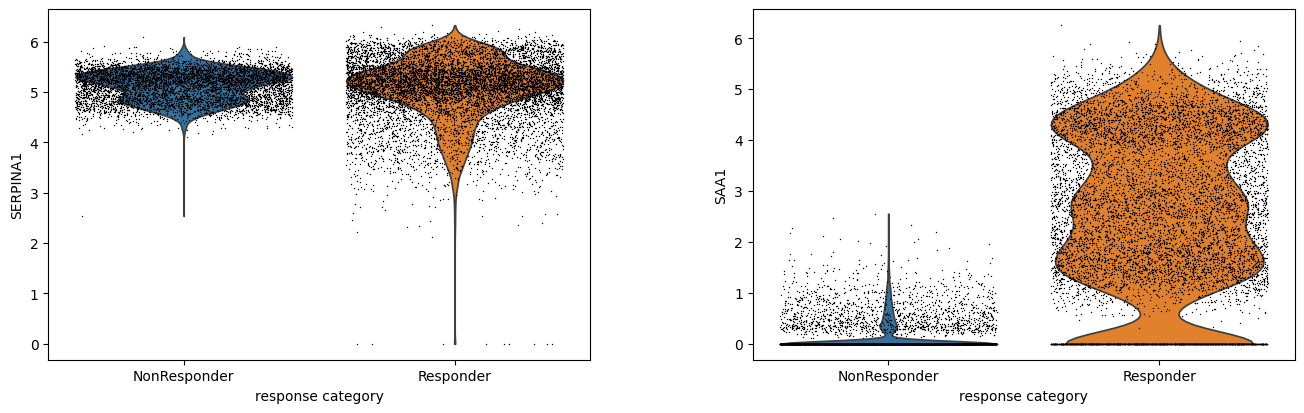

In [187]:
#5. Filtering Low-Quality Cells
#Concept: Remove cells with low gene counts or low total counts to reduce noise in downstream analyses.
# Scale data
# Filter cells and genes
sc.pp.filter_cells(adata, min_genes=200)  # Keep cells with at least 200 genes
sc.pp.filter_genes(adata, min_cells=3)   # Keep genes expressed in at least 3 cells

# Revisualize after filtering
sc.pl.violin(adata, keys=[gene1, gene2], groupby='sample', jitter=0.4, multi_panel=True)
sc.pl.violin(adata, keys=[gene1, gene2], groupby='response_category', jitter=0.4, multi_panel=True)

In [188]:
# Check filtered adata object
adata

AnnData object with n_obs × n_vars = 15790 × 23820
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'center_x', 'center_y', 'response_category', 'total_counts', 'size_factors', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'sample_colors', 'response_category_colors', 'log1p'
    obsm: 'spatial'

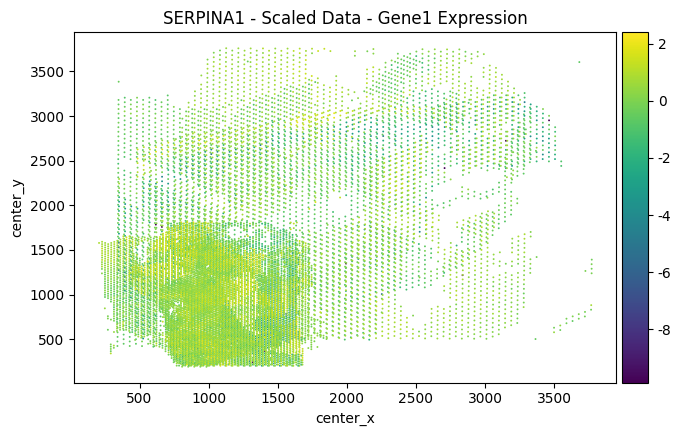

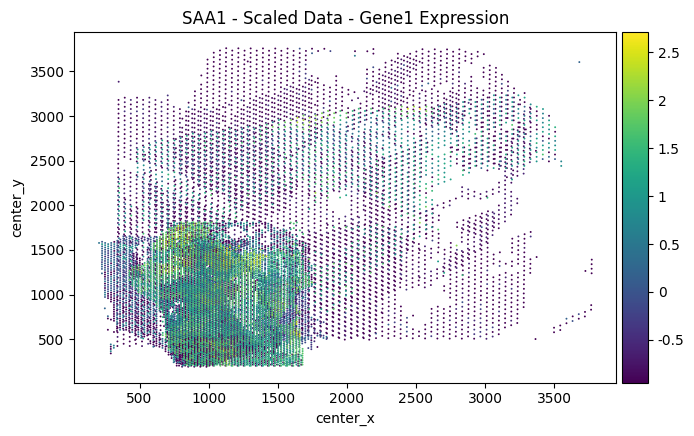

In [189]:
#6. Scaling Gene Expression
# Concept: Scale each gene to unit variance and zero mean for comparative analyses.
# Scale data
sc.pp.scale(adata)

# Scatter plot to visualize spatial data after scaling
sc.pl.scatter(adata, x='center_x', y='center_y', color=gene1, color_map='viridis', 
              title='SERPINA1 - Scaled Data - Gene1 Expression', show=True)
sc.pl.scatter(adata, x='center_x', y='center_y', color=gene2, color_map='viridis', 
              title='SAA1 - Scaled Data - Gene1 Expression', show=True)

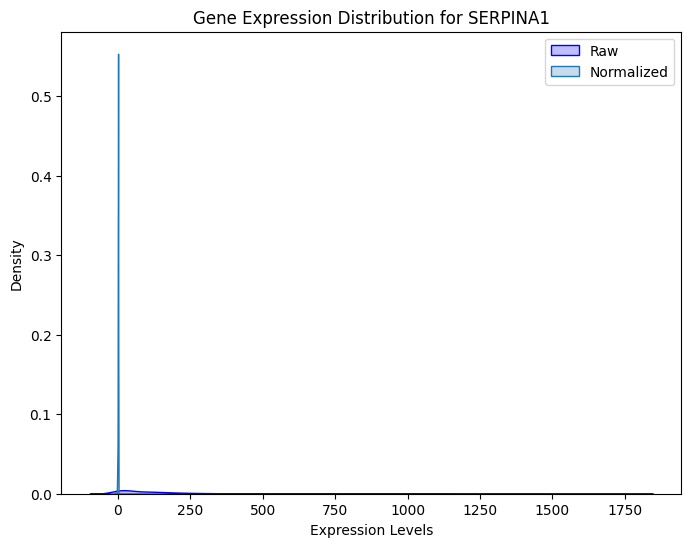

In [191]:
#7. Compare Distributions Before and After Normalization
#Concept: Highlight the impact of normalization and log transformation using histograms or density plots.

# Gene of interest
gene = "SERPINA1"
gene_index = adata_org.var_names.get_loc(gene)  # Get index of the gene in .var_names

# Raw values
raw_values = adata_org.X[:, gene_index].toarray().flatten() if sp.issparse(adata_org.X) else adata_org.X[:, gene_index]

# Normalized values
norm_values = adata[:, gene].X.toarray().flatten() if sp.issparse(adata.X) else adata[:, gene].X

# Plot distributions
plt.figure(figsize=(8, 6))
sns.kdeplot(raw_values, label='Raw', color='blue', fill=True)
sns.kdeplot(norm_values, label='Normalized', color='orange', fill=True)
plt.title(f"Gene Expression Distribution for {gene}")
plt.xlabel("Expression Levels")
plt.ylabel("Density")
plt.legend()
plt.show()

In [190]:
adata_org

AnnData object with n_obs × n_vars = 17292 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'center_x', 'center_y', 'response_category'
    var: 'gene_ids', 'feature_types'
    obsm: 'spatial'